In [2]:
#!/usr/bin/env python
import numpy as np
import pandas as pd
import argparse
import copy
import torch
import torch.nn as nn
import joblib
import time
import sys
import os
import random
from matplotlib import pyplot as plt
from eval_sparseloader import DataLoader
from eval_data import LibSVMData, LibCSVData, LibSVMRegData
from eval_sparse_data import LibSVMDataSp
sys.path.append('/Users/nelvis/Documents/R/GrowNet/Regression')
from models.mlp import MLP_1HL, MLP_2HL, MLP_3HL
from models.dynamic_net import DynamicNet, ForwardType
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.optim import SGD, Adam

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Prepare Data

In [43]:
df = pd.read_csv('/Users/nelvis/Documents/R/GrowNet/Regression/data/datwTestTrainSplit.csv')

list_of_features = [
    "claim_no",
    "occurrence_time", 
    "notidel", 
    "development_period", 
    "pmt_no",
    "log1_paid_cumulative",
    "max_paid_dev_factor",
    "min_paid_dev_factor",
]
output_field = ["claim_size"]
youtput="claim_size"

In [44]:
# Only take training subsection, we save the TEST part for the final final final validation
df_train = df.query('train_ind == 1')
df_test = df.query('train_ind == 0')
df_one = df.head(1)

# Only consider relevant columns
df_train = df_train.filter(items = list_of_features + [youtput])
df_test = df_test.filter(items = list_of_features + [youtput])
df_one = df_one.filter(items = list_of_features + [youtput])

# Extract values
X_train, y_train = df_train.iloc[:, :8].values, df_train.iloc[:,[8]]
X_test, y_test = df_test.iloc[:, :8].values, df_test.iloc[:,[8]]
X_one, y_one = df_one.iloc[:, :8].values, df_one.iloc[:,[8]]

In [6]:
# Saving train and test into npz file
np.savez('datwTestTrainSplit_train.npz', features=X_train, labels=y_train)
np.savez('datwTestTrainSplit_test.npz', features=X_test, labels=y_test)
np.savez('datwTestTrainSplit_one.npz', features=X_one, labels=y_one)

# Load Model

In [7]:
class Options(object):
    def __init__(self, feat_d, hidden_d, batch_size, normalization, train, test, one) -> None:
        self.feat_d = feat_d
        self.hidden_d = hidden_d
        self.sparse = False
        self.batch_size = batch_size
        self.normalization = normalization
        self.tr = train
        self.te = test
        self.one = one

In [8]:
opt = Options(feat_d = 8, hidden_d = 32, batch_size = 2048, normalization = True, 
              train = "/Users/nelvis/Documents/R/GrowNet/Regression/ckpt/datwTestTrainSplit_train.npz", 
              test = "/Users/nelvis/Documents/R/GrowNet/Regression/ckpt/datwTestTrainSplit_test.npz",
              one = "/Users/nelvis/Documents/R/GrowNet/data/datwTestTrainSplit_te.npz")

In [16]:
train = LibSVMRegData(opt.tr, opt.feat_d, opt.normalization)
test = LibSVMRegData(opt.te, opt.feat_d, opt.normalization)
one = LibSVMRegData(opt.one, opt.feat_d, opt.normalization)

8
8
8


In [17]:
if opt.normalization:
        scaler = joblib.load('/Users/nelvis/Documents/R/GrowNet/Regression/ckpt/datwTestTrainSplit_scaler.pkl')
        one.feat = scaler.transform(one.feat)
        test.feat = scaler.transform(test.feat)
        train.feat = scaler.transform(train.feat)

/usr/local/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [32]:
train_loader = DataLoader(train, opt.batch_size, shuffle=False, drop_last=False, num_workers=0)
test_loader = DataLoader(test, opt.batch_size, shuffle=False, drop_last=False, num_workers=0)
one_loader = DataLoader(one, opt.batch_size, shuffle=False, drop_last=False, num_workers=0)

In [20]:
net_ensemble = DynamicNet.from_file("./datwTestTrainSplit_cls.pth", lambda stage: MLP_2HL.get_model(stage, opt))

# Compute RMSE

In [21]:
net_ensemble.to_eval()

In [14]:
def root_mse(net_ensemble, loader):
    loss = 0
    total = 0
 
    for x, y in loader:
        #if opt.cuda:
        #    x = x.cuda()

        with torch.no_grad():
            _, out = net_ensemble.forward(x)
        y = y.cpu().numpy().reshape(len(y), 1)
        out = out.cpu().numpy().reshape(len(y), 1)
        loss += mean_squared_error(y, out)* len(y)
        total += len(y)
    return np.sqrt(loss / total)

In [22]:
root_mse(net_ensemble, one_loader)

94342.64898862866

In [23]:
root_mse(net_ensemble, train_loader)

125403.81390795553

In [24]:
root_mse(net_ensemble, test_loader)

127288.05177433712

# Create results dataset

In [49]:
out_test = torch.empty(0)

for x, y in test_loader:
    with torch.no_grad():
            _, out_tmp = net_ensemble.forward(x)
    out_test = torch.cat([out_test, out_tmp])

out_train = torch.empty(0)

for x, y in train_loader:
    with torch.no_grad():
            _, out_tmp = net_ensemble.forward(x)
    out_train = torch.cat([out_train, out_tmp])

In [62]:
np.ceil(0.1)

1.0

In [69]:
df_test['claim_size_predicted'] = out_test.numpy().flatten()
df_train['claim_size_predicted'] = out_train.numpy().flatten()

df_test['train_ind'] = False
df_train['train_ind'] = True

df_complete = df_train.append(df_test)
df_complete['occurrence_period'] = df_complete['occurrence_time'].apply(lambda x : np.ceil(x))

In [64]:
df_complete.head()

,claim_no,occurrence_time,notidel,development_period,pmt_no,log1_paid_cumulative,max_paid_dev_factor,min_paid_dev_factor,claim_size,claim_size_predicted,train_ind,occurrence_period
117,4,0.743975,0.419228,1,0.0,0.000000,0.0,0.0,227599.310366,146466.09375,1,1.0
118,4,0.743975,0.419228,2,1.0,9.198996,0.0,0.0,227599.310366,274087.43750,1,1.0
119,4,0.743975,0.419228,3,1.0,9.198996,1.0,1.0,227599.310366,248411.09375,1,1.0
120,4,0.743975,0.419228,4,1.0,9.198996,1.0,1.0,227599.310366,234193.15625,1,1.0
121,4,0.743975,0.419228,5,1.0,9.198996,1.0,1.0,227599.310366,220011.03125,1,1.0


# Visualization

In [65]:
# Diagnostic model subplots
# We will be repeating this logic across multiple models, so put logic into function for repeatability

#COULD PLOT MEAN OR SUM

def make_model_subplots(df):
    fig, axes = plt.subplots(3, 2, sharex='all', sharey='all', figsize=(15, 15))

    (df
        .loc[lambda df: df.train_ind]
        .groupby(["occurrence_period"])
        .agg({youtput: "mean", "claim_size_predicted": "mean"})
    ).plot(ax=axes[0,0], logy=True)
    axes[0,0].title.set_text("Train, Occur")

    (df
        .loc[lambda df: df.train_ind]
        .groupby(["development_period"])
        .agg({youtput: "mean", "claim_size_predicted": "mean"})
    ).plot(ax=axes[0,1], logy=True)
    axes[0,1].title.set_text("Train, Dev")

    (df
        .loc[lambda df: ~df.train_ind]
        .groupby(["occurrence_period"])
        .agg({youtput: "mean", "claim_size_predicted": "mean"})
    ).plot(ax=axes[1,0], logy=True)
    axes[1,0].title.set_text("Test, Occ")

    (df
        .loc[lambda df: ~df.train_ind]
        .groupby(["development_period"])
        .agg({youtput: "mean", "claim_size_predicted": "mean"})
    ).plot(ax=axes[1,1], logy=True)
    axes[1,1].title.set_text("Test, Dev")

    (df
        .groupby(["occurrence_period"])
        .agg({youtput: "mean", "claim_size_predicted": "mean"})
    ).plot(ax=axes[2,0], logy=True)
    axes[2,0].title.set_text("All, Occ")

    (df
        .groupby(["development_period"])
        .agg({youtput: "mean", "claim_size_predicted": "mean"})
    ).plot(ax=axes[2,1], logy=True)
    axes[2,1].title.set_text("All, Dev")

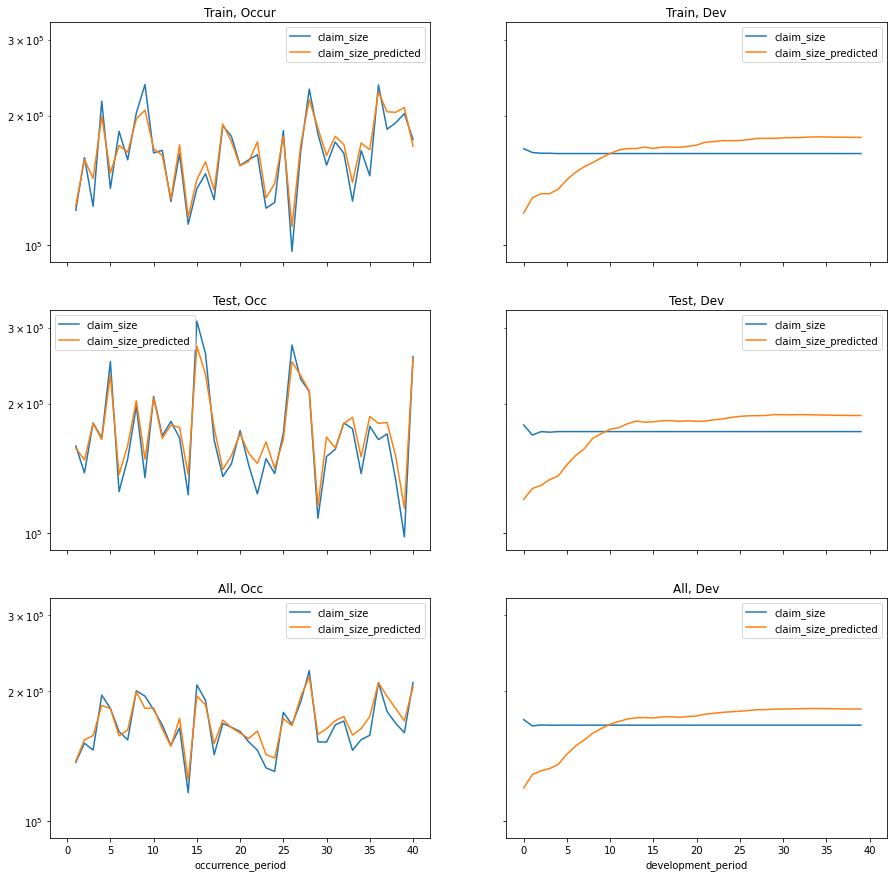

In [70]:
make_model_subplots(df_complete)

# Load results from training

In [184]:
training_results = np.load('/Users/nelvis/Documents/R/GrowNet/Regression/results/datwTestTrainSplit_rmse.npz',
                           allow_pickle = True)

In [185]:
training_results['rmse']

array([[266753.62, 185097.88,      0.  ],
       [266623.97, 185000.1 ,      0.  ],
       [266328.2 , 184752.27,      0.  ],
       [265836.53, 184337.92,      0.  ],
       [264906.4 , 183530.72,      0.  ],
       [264030.3 , 182802.86,      0.  ],
       [262574.4 , 181622.38,      0.  ],
       [261187.27, 180582.42,      0.  ],
       [260015.52, 179691.61,      0.  ],
       [255709.88, 176111.67,      0.  ],
       [250062.03, 171962.92,      0.  ],
       [250889.73, 172617.03,      0.  ],
       [242953.5 , 166382.03,      0.  ],
       [232219.  , 156184.23,      0.  ],
       [224283.4 , 151828.38,      0.  ],
       [213708.12, 144387.7 ,      0.  ],
       [215110.75, 145047.89,      0.  ],
       [208653.31, 140304.14,      0.  ],
       [200601.95, 131433.23,      0.  ],
       [199986.05, 133467.58,      0.  ]], dtype=float32)

In [196]:
training_results['params']

array(Namespace(feat_d=8, hidden_d=32, boost_rate=1.0, lr=0.0025, num_nets=20, data='datwTestTrainSplit', tr='./../data/datwTestTrainSplit_tr.npz', te='./../data/datwTestTrainSplit_te.npz', batch_size=2048, epochs_per_stage=1, correct_epoch=1, L2=0.0, sparse=False, normalization=True, cv=True, out_f='./ckpt//datwTestTrainSplit_cls.pth', cuda=False),
      dtype=object)